In [247]:
import os
import torch
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import matplotlib.pyplot as plt
from pyro.contrib.gp.kernels import Product
import pandas as pd
import torch.nn.functional as F
smoke_test = "CI" in os.environ  # ignore; used to check code integrity in the Pyro repo
assert pyro.__version__.startswith('1.9.1')

In [248]:
pyro.clear_param_store()

In [249]:
data = pd.read_csv("la_temperature.csv", parse_dates=["time"], index_col="time")
X0 = torch.arange(len(data)).float() / 365.25
y0 = torch.tensor(data["tavg"].values).float()
X = X0[:-200]
y = y0[:-200]
y = torch.tensor(y)
X = torch.tensor(X)
Xend = 4.5

C:\Users\frang\AppData\Local\Temp\ipykernel_11796\2754344034.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y)
C:\Users\frang\AppData\Local\Temp\ipykernel_11796\2754344034.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X)


In [250]:
def plot(
    plot_observed_data=False,
    plot_predictions=False,
    n_prior_samples=0,
    model=None,
    kernel=None,
    n_test=500,
    ax=None,
):

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    if plot_observed_data:
        ax.plot(X.numpy(), y.numpy(), "kx")
    if plot_predictions:
        Xtest = torch.linspace(-0.5, 0.5+Xend, n_test)  # test inputs
        # compute predictive mean and variance
        with torch.no_grad():
            if type(model) == gp.models.VariationalSparseGP:
                mean, cov = model(Xtest, full_cov=True)
            else:
                mean, cov = model(Xtest, full_cov=True, noiseless=False)
        sd = cov.diag().sqrt()  # standard deviation at each input point x
        ax.plot(Xtest.numpy(), mean.numpy(), "r", lw=2)  # plot the mean
        ax.fill_between(
            Xtest.numpy(),  # plot the two-sigma uncertainty about the mean
            (mean - 2.0 * sd).numpy(),
            (mean + 2.0 * sd).numpy(),
            color="C0",
            alpha=0.3,
        )
    if n_prior_samples > 0:  # plot samples from the GP prior
        Xtest = torch.linspace(-0.5, 0.5+Xend, n_test)  # test inputs
        noise = (
            model.noise
            if type(model) != gp.models.VariationalSparseGP
            else model.likelihood.variance
        )
        cov = kernel.forward(Xtest) + noise.expand(n_test).diag()
        samples = dist.MultivariateNormal(
            torch.zeros(n_test), covariance_matrix=cov
        ).sample(sample_shape=(n_prior_samples,))
        ax.plot(Xtest.numpy(), samples.numpy().T, lw=2, alpha=0.4)

    ax.set_xlim(-0.5, 0.5+Xend)

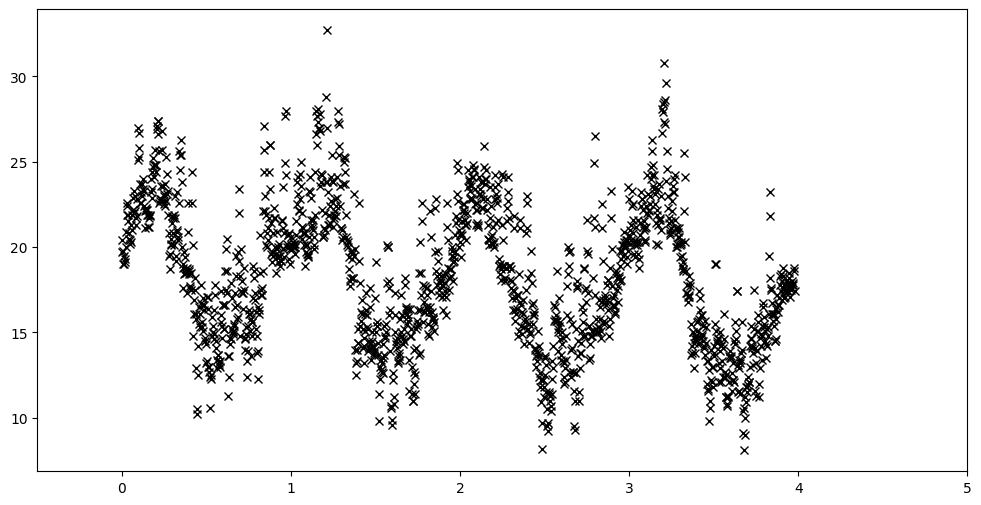

In [251]:
plot(plot_observed_data=True)

In [ ]:
n_induced = 200.
Xu = torch.arange(n_induced)*Xend/n_induced
pyro.clear_param_store()
rbf_kernel = gp.kernels.RBF(input_dim=1)
periodic_kernel = gp.kernels.Periodic(input_dim=1, period=torch.tensor(1.))
kernel = Product(rbf_kernel, periodic_kernel)

sgpr = gp.models.SparseGPRegression(X, y, kernel, Xu=Xu, jitter=1.0e-3)


optimizer = torch.optim.Adam(sgpr.parameters(), lr=0.005)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
locations = []
noises = []
num_steps = 2000
for i in range(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(sgpr.model, sgpr.guide)
    locations.append(sgpr.Xu.data.numpy().copy())
    noises.append(sgpr.noise.item())
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

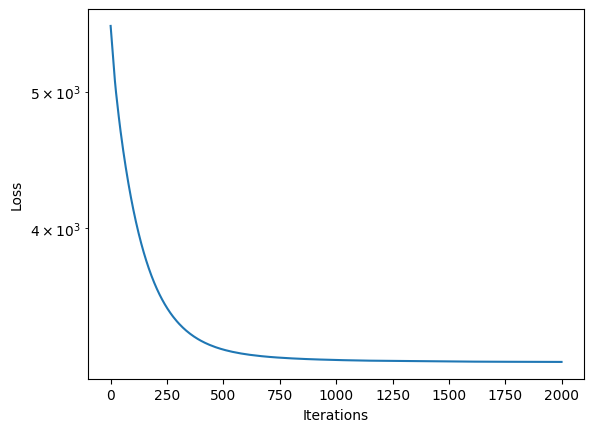

In [253]:
def plot_loss(loss):
    plt.plot(loss)
    plt.yscale('log')
    plt.xlabel("Iterations")
    _ = plt.ylabel("Loss")  # supress output text


plot_loss(losses)

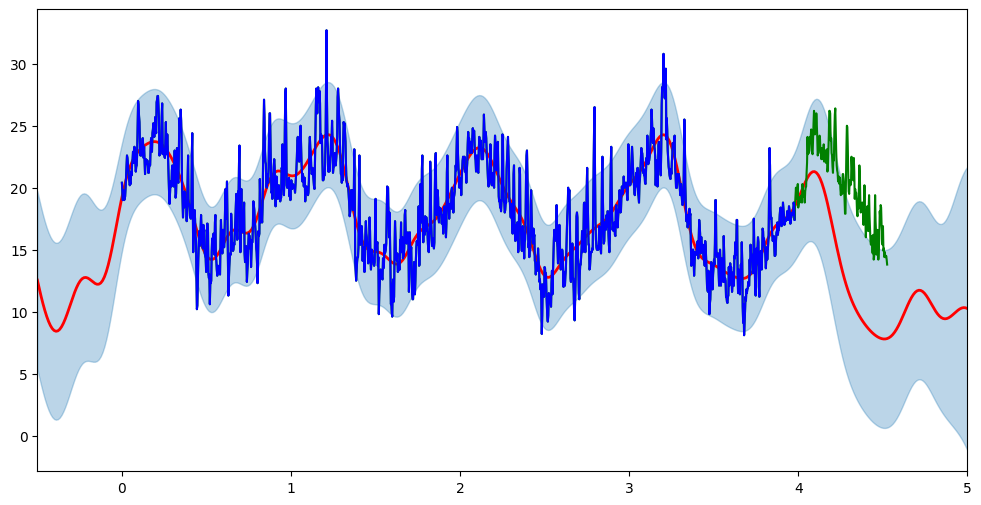

In [254]:
plot(model=sgpr, plot_observed_data=False, plot_predictions=True)
plt.plot(X0,y0, 'g')
plt.plot(X,y, 'b')

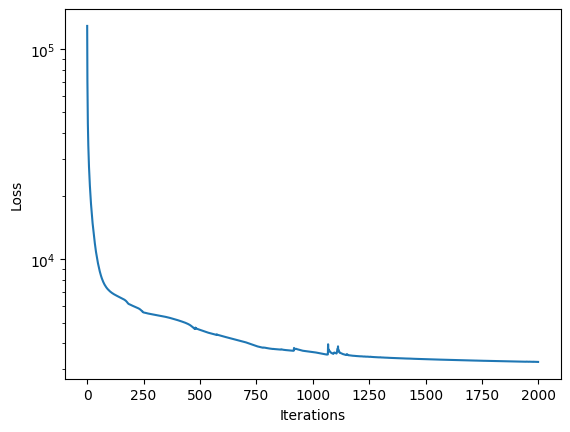

In [255]:
n_induced = 200.
Xu = torch.arange(n_induced)*Xend/n_induced

# initialize the kernel, likelihood, and model
pyro.clear_param_store()
kernel = gp.kernels.RBF(input_dim=1)
likelihood = gp.likelihoods.Gaussian()
# turn on "whiten" flag for more stable optimization
vsgp = gp.models.VariationalSparseGP(
    X, y, kernel, Xu=Xu, likelihood=likelihood, whiten=True, jitter=1.0e-3
)

# instead of defining our own training loop, we will
# use the built-in support provided by the GP module
num_steps = 2000 if not smoke_test else 2
losses = gp.util.train(vsgp, num_steps=num_steps)
plot_loss(losses)

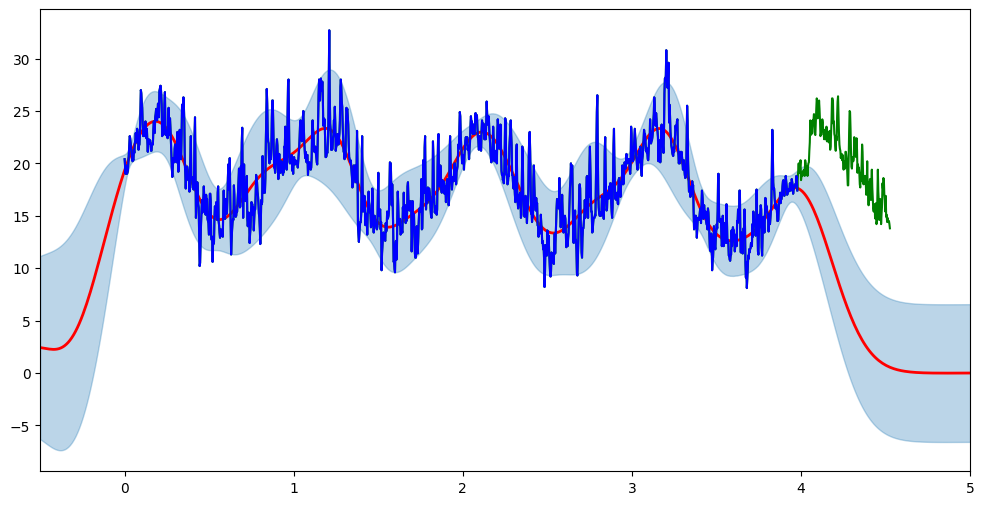

In [256]:
plot(model=vsgp, plot_observed_data=False, plot_predictions=True)
plt.plot(X0,y0, 'g')
plt.plot(X,y, 'b')

In [257]:
f_loc, f_var = sgpr(X0, full_cov=False)
rmse = torch.sqrt(F.mse_loss(f_loc, y0))
mae = F.l1_loss(f_loc, y0)
print("SGPR  RMSE: {}".format(rmse))
print("SGPR  MAE: {}".format(mae))

SGPR  RMSE: 3.0858919620513916
SGPR  MAE: 2.1043248176574707


In [258]:
f_loc, f_var = vsgp(X0, full_cov=False)
rmse = torch.sqrt(F.mse_loss(f_loc, y0))
mae = F.l1_loss(f_loc, y0)
print("Variational SGP  RMSE: {}".format(rmse))
print("Variational SGP  MAE: {}".format(mae))

Variational SGP  RMSE: 4.936835289001465
Variational SGP  MAE: 2.8634796142578125
